# Frequency Encoder 
In this notebook we analyze the output of the `FrequencyEncoder` on the UCR Phoneme dataset.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import mlab 
import numpy as np

%matplotlib inline

# Load dataset

In [2]:
# Util functions to load a UCR dataset
def load(csv_path):
    df = pd.read_csv(csv_path)
    df.columns = ['label'] + ['t%s' % i for i in range(len(df.columns) - 1)]
    return df

In [3]:
df = load('UCR_TS_Archive_2015/Phoneme/Phoneme_TEST')
print 'timeserie length:', len(df.columns)
print 'nb timeseries:', len(df)
print 'columns:', df.columns.values
print 'total number of labels:', len(df.label.unique())

min_samples_per_label = 50
good_labels = []
for l in df.label.unique():
    c = len(df[df.label ==l])
    if c > min_samples_per_label:
        good_labels.append(l)
print 'good labels (with at least %s samples): %s' %(min_samples_per_label, good_labels)

good_labels = [23,31]

timeserie length: 1025
nb timeseries: 1895
columns: ['label' 't0' 't1' ..., 't1021' 't1022' 't1023']
total number of labels: 39
good labels (with at least 50 samples): [3, 9, 11, 12, 17, 18, 20, 21, 22, 23, 27, 28, 29, 31]


# Plot phonemes

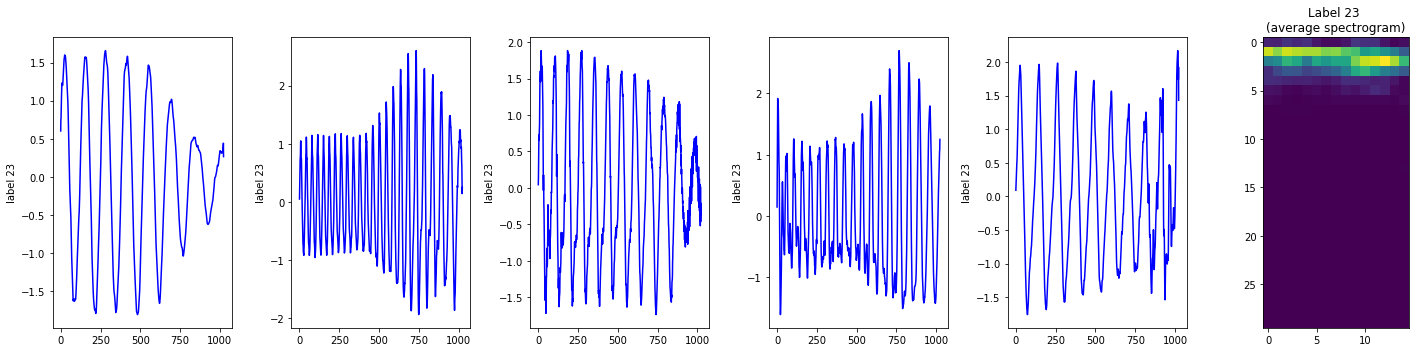

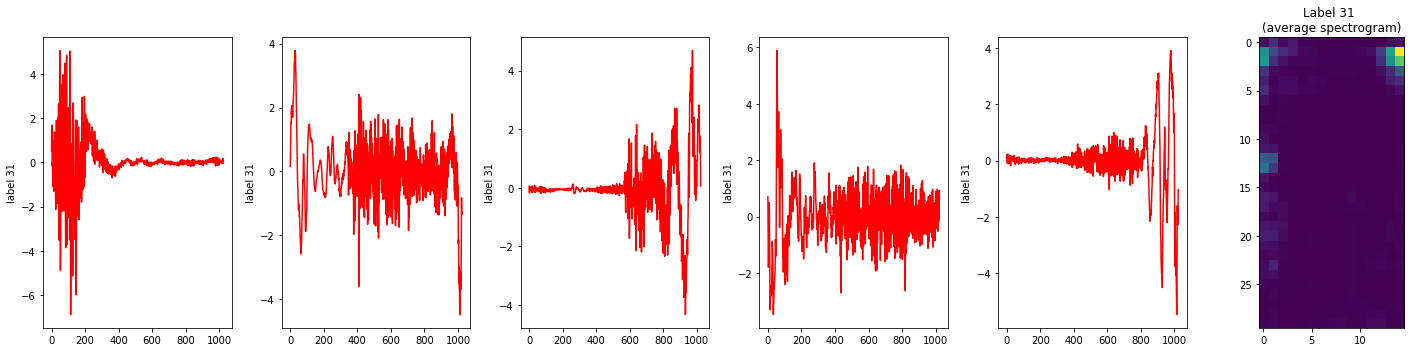

In [4]:
nb_samples = 5
start_label = 0
max_freq = 30
nb_labels = len(good_labels)
labels = good_labels[start_label:start_label+nb_labels]
colors = ['b', 'r', 'g'] 
for k in range(nb_labels):
    l = labels[k]
    c = colors[k]
    plt.figure(figsize=(20,5))

    freqs_list = []
    for i in range(nb_samples):
        data = df[df.label==l].iloc[i,1:].values
        
        freqs, m2, m3 = mlab.specgram(data, NFFT=128, noverlap=64)
        freqs_list.append(freqs.tolist())
        
        plt.subplot(1,nb_samples+1,i+1)
        plt.plot(data, color=c)
        plt.ylabel('label %s' % l)
        
    mean_freqs = np.mean(np.array(freqs_list), axis=0)
    assert freqs.shape == mean_freqs.shape
    plt.subplot(1,nb_samples+1,nb_samples+1)
    plt.imshow(mean_freqs[:max_freq,:], interpolation='nearest')
    plt.title('Label %s \n(average spectrogram)' % l)
    
    plt.tight_layout()

# Check FFT with simple sine wave

0.999874127674 7.80581017517


(0, 30)

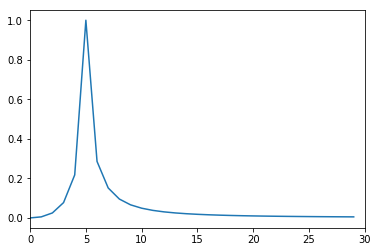

In [5]:
# Sine wave
from frequency_encoder import getFreqs

f = 5
x = np.linspace(0,100, 100)
data = np.sin(x*2*np.pi * f) 

fftData = getFreqs(data)

print np.max(data), np.max(fftData)
fftData = fftData[:max_freq] / np.max(fftData)

plt.figure()
plt.plot(fftData)
plt.xlim(0, max_freq)

# Utility function to plot encodings

In [6]:
from frequency_encoder import getFreqs, pprint

def plot_encoding(inputData, encoding, minval, maxval, title, color=None):
    if color is None: color = 'b'

    # Raw data
    plt.figure(figsize=(15,4))
    ax1 = plt.subplot(131)
    ax1.plot(inputData, c=color)
    ax1.set_title(title)
    
    # FFT
    fftData=getFreqs(inputData)
    ax2 = plt.subplot(132)
    ax2.plot(range(len(fftData)), fftData, c=color)
    
    w =  (maxval-minval) / (freqBinN/freqBinW)
    for i in range(freqBinN/freqBinW):
        ax2.axhline(i*w, c='grey', ls='-.')

    w = len(fftData) / numFrequencyBins
    for k in range(numFrequencyBins):
        ax2.axvline(k*w, c='grey', ls='-.')

    ax2.set_xlim(0, len(fftData))
    ax2.set_ylim(minval, maxval)
    ax2.set_title('FFT')
    
    # Encoding
    ax3 = plt.subplot(133)
    ax3.imshow(np.flipud(encoding.reshape((numFrequencyBins, freqBinN)).T), cmap='Greys')
    ax3.set_xticks([])
    ax3.set_yticks([])
    ax3.set_title('Encoding')
    plt.tight_layout()

# Encoding of sine waves

In [12]:
from frequency_encoder import FrequencyEncoder, pprint

numFrequencyBins = 8
freqBinN = 8
freqBinW = 1
minval = 0.0
maxval = 12.0


sineEncoder = FrequencyEncoder(numFrequencyBins, freqBinN, freqBinW, minval, maxval)

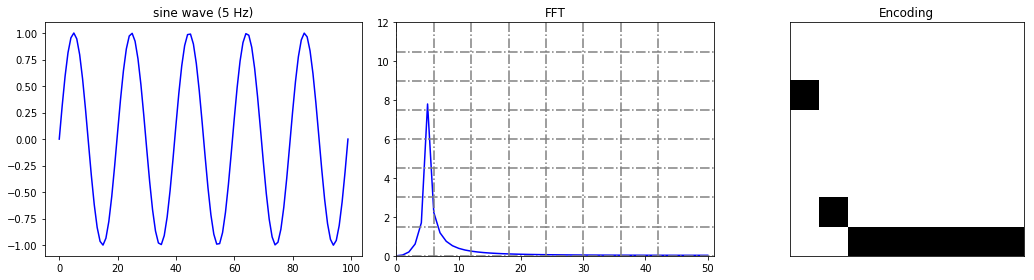

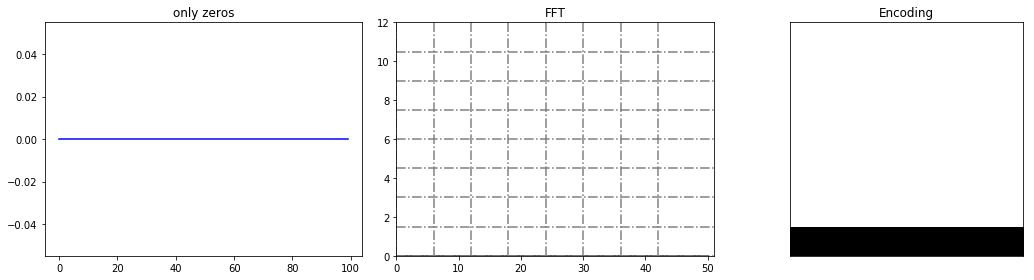

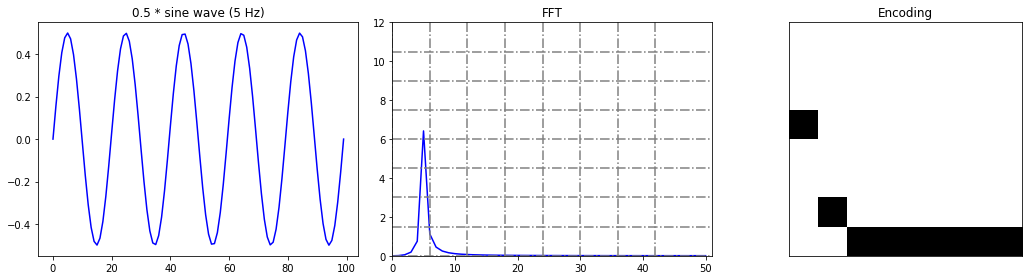

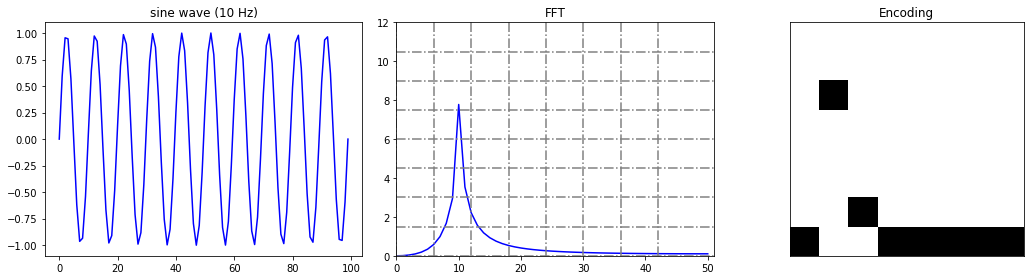

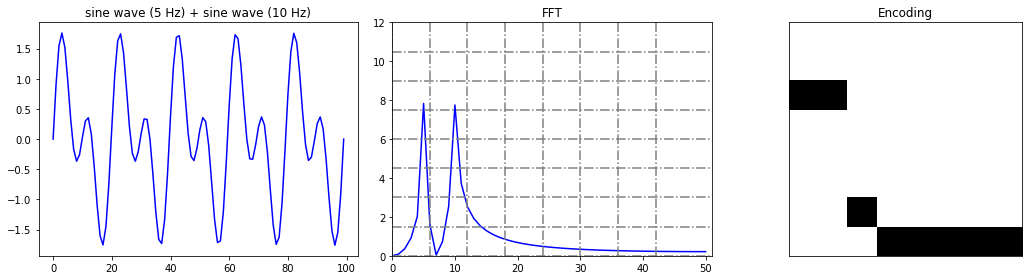

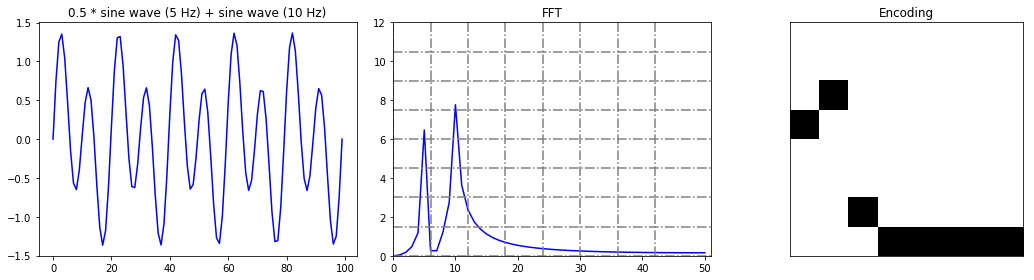

In [13]:
x = np.linspace(0, 100, 100)


title = 'sine wave (5 Hz)'
f = 5
inputData = np.sin(x * 2 * np.pi * f)
encoding = sineEncoder.encode(inputData)
plot_encoding(inputData, encoding, minval, maxval, title)

title = 'only zeros'
inputData = np.zeros(len(x))
encoding = sineEncoder.encode(inputData)
plot_encoding(inputData, encoding, minval, maxval, title)

title = '0.5 * sine wave (5 Hz)'
f = 5
inputData = 0.5 * np.sin(x * 2 * np.pi * f)
encoding = sineEncoder.encode(inputData)
plot_encoding(inputData, encoding, minval, maxval, title)


title = 'sine wave (10 Hz)'
f = 10
inputData = np.sin(x * 2 * np.pi * f)
encoding = sineEncoder.encode(inputData)
plot_encoding(inputData, encoding, minval, maxval, title)

title = 'sine wave (5 Hz) + sine wave (10 Hz)'
f = 5
inputData = np.sin(x * 2 * np.pi * f) + np.sin(x * 2 * np.pi * 2 * f)
encoding = sineEncoder.encode(inputData)
plot_encoding(inputData, encoding, minval, maxval, title)


title = '0.5 * sine wave (5 Hz) + sine wave (10 Hz)'
f = 5
inputData = 0.5 * np.sin(x * 2 * np.pi * f) + np.sin(x * 2 * np.pi * 2 * f)
encoding = sineEncoder.encode(inputData)
plot_encoding(inputData, encoding, minval, maxval, title)

# Encodings of phonemes

In [14]:
print good_labels

[23, 31]


In [18]:
from frequency_encoder import FrequencyEncoder, pprint

numFrequencyBins = 32
freqBinN = 32
freqBinW = 1
minval = 0.0
maxval = 14.0

phonemeEncoder = FrequencyEncoder(numFrequencyBins, freqBinN, freqBinW, minval, maxval)

In [19]:
label = good_labels[0]
ts_idx = 0
phoneme = df[df.label==label].iloc[ts_idx,1:].values

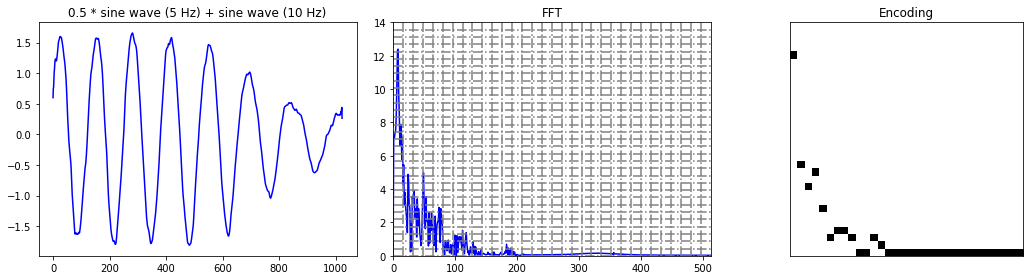

In [20]:
n_chunks = 1
chunk_w = len(phoneme)/ n_chunks

for i in range(n_chunks):
    inputData = phoneme[i*chunk_w:(i+1)*chunk_w]
    encoding = phonemeEncoder.encode(inputData)
    plot_encoding(inputData, encoding, minval, maxval, title)

## Chunk phoneme over time

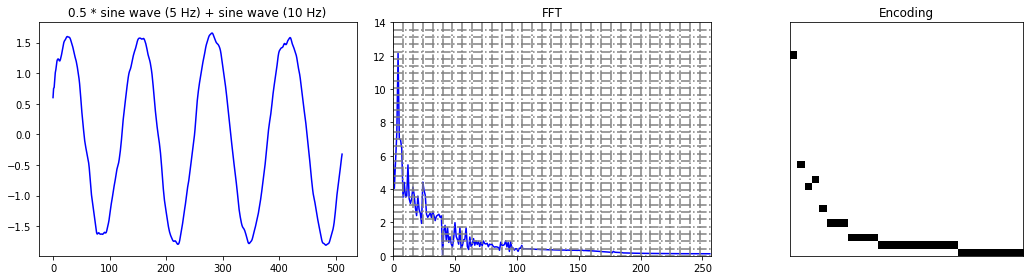

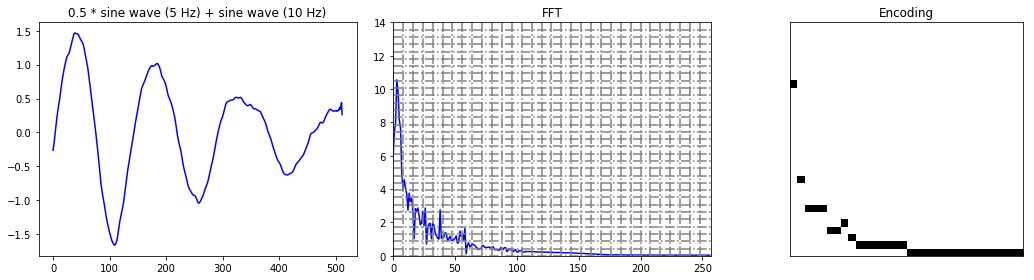

In [21]:
n_chunks = 2
chunk_w = len(phoneme)/ n_chunks

for i in range(n_chunks):
    inputData = phoneme[i*chunk_w:(i+1)*chunk_w]
    encoding = phonemeEncoder.encode(inputData)
    plot_encoding(inputData, encoding, minval, maxval, title)

# Look at phoneme classes 23 and 31

In [22]:
print good_labels

[23, 31]


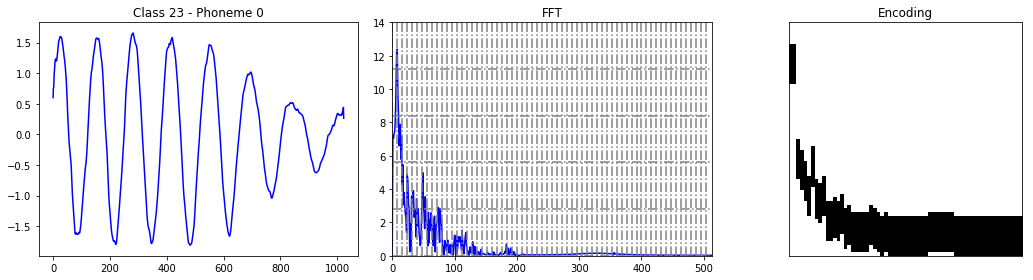

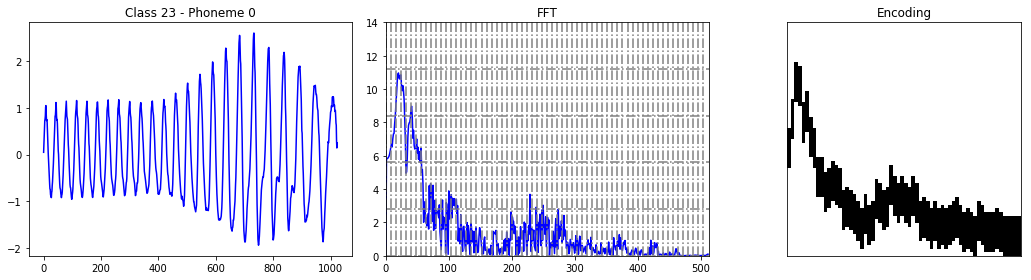

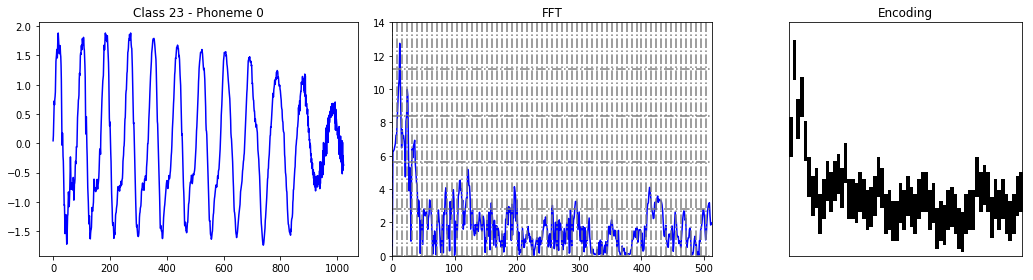

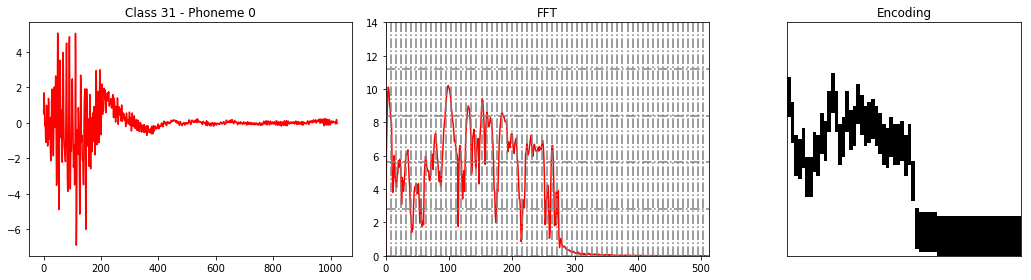

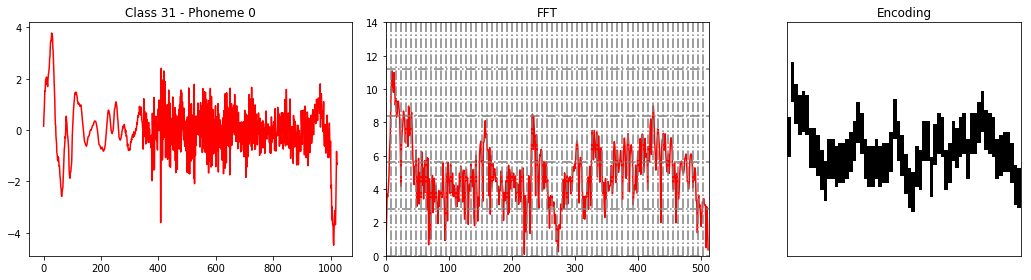

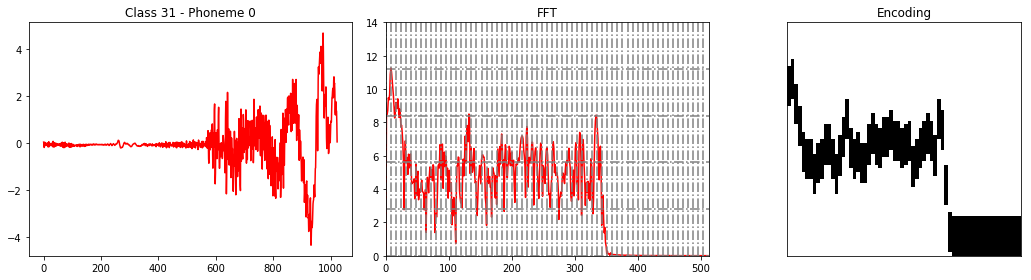

In [23]:
from frequency_encoder import FrequencyEncoder, pprint

numFrequencyBins = 64
freqBinN = 64
freqBinW = 11
minval = 0.0
maxval = 14.0

encoder = FrequencyEncoder(numFrequencyBins, freqBinN, freqBinW, minval, maxval)

n_chunks = 1
n_phonemes = 3
offset = 0

phoneme_length = len(df.columns) - 1
chunk_w = phoneme_length / n_chunks
colors = ['b', 'r', 'g']
for label in good_labels:
    for phoneme_idx in range(len(df))[offset:offset+n_phonemes]:
        phoneme = df[df.label==label].iloc[phoneme_idx,1:].values
        for i in range(n_chunks):
            d = phoneme[i*chunk_w:(i+1)*chunk_w]
            encoding = encoder.encode(d)
            title = 'Class %s - Phoneme %s' % (label, ts_idx)
            label_idx = good_labels.index(label)
            color = colors[label_idx]
            plot_encoding(d, encoding, minval, maxval, title, color)

In [24]:
n_chunks = 1

phoneme_length = len(df.columns) - 1
chunk_w = phoneme_length / n_chunks
encodings = []
n_phonemes_per_label = []
for label in good_labels:
    phonemes = df[df.label==label].iloc[:,1:]
    n_phonemes_per_label.append(len(phonemes))
    for phoneme_idx in range(len(phonemes)):
        phoneme = phonemes.iloc[phoneme_idx,:].values
        for i in range(n_chunks):
            d = phoneme[i*chunk_w:(i+1)*chunk_w]
            encoding = encoder.encode(d)
            encodings.append(encoding)

print zip(good_labels, n_phonemes_per_label)

[(23, 134), (31, 130)]


In [25]:
def euclidian(a, b):
    return np.linalg.norm(a-b) 

def overlap(a, b):
    return 1 - np.sum((a==b)) / float(len(a))

In [26]:
# distance matrix
dist = overlap

N = len(encodings)
mat = np.zeros((N,N))

for i in range(N):
    for j in range(N):
        mat[i,j] = dist(encodings[i], encodings[j])
        mat[j,i] = mat[i,j]

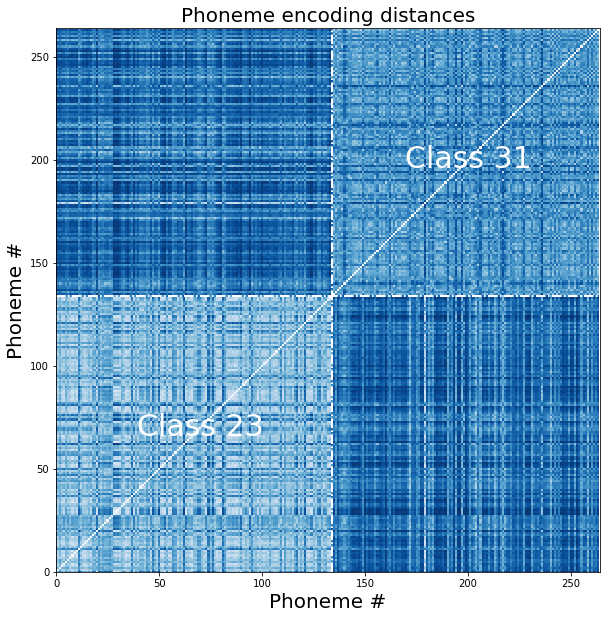

In [27]:
plt.figure(figsize=(10,10))
plt.imshow(mat, cmap='Blues')
cumul_sum = 0
for x in n_phonemes_per_label:
    cumul_sum += x
    plt.axhline(cumul_sum, c='w', ls='-.', linewidth=2)
    plt.axvline(cumul_sum, c='w', ls='-.', linewidth=2)
plt.xlim(0, N)
plt.ylim(0, N)
plt.xlabel('Phoneme #', fontsize=20)
plt.ylabel('Phoneme #', fontsize=20)
plt.title('Phoneme encoding distances', fontsize=20)

def plot_text(text, idx, fontsize):
    plt.annotate(text, xy=(idx, idx), xytext=(idx, idx), color='w', 
                 fontsize=fontsize, horizontalalignment='center', verticalalignment='center')

fontsize = 30
plot_text('Class 23', 70, fontsize)
plot_text('Class 31', 200, fontsize)